In [1]:
import pandas as pd
import networkx as nx
import os
import matplotlib.pyplot as plt

os.getcwd()

'/Users/mohan/Library/Mobile Documents/com~apple~CloudDocs/Saras AI/Semester 7/Data Structures and Algorithms/Project/Emergency_Response_Dispatch_System/notebooks'

In [2]:
locations = pd.read_csv("../datasets/location.csv")
roads = pd.read_csv('../datasets/roads.csv')

In [3]:
locations.head()

,id,name,latitude,longitude,category
0,L1,Connaught Place,28.6315,77.2167,Market
1,L2,AIIMS Delhi,28.5662,77.2100,Hospital
2,L3,Safdarjung Hospital,28.5677,77.2109,Hospital
3,L4,India Gate,28.6129,77.2295,Tourist
4,L5,New Delhi Railway Station,28.6430,77.2194,Transport


In [4]:
G = nx.Graph()

In [5]:
categories = {}


### Adding Nodes to the Graph Network


In [6]:
for id, name, category in locations.loc[:, ['id', 'name', 'category']].values:
    G.add_nodes_from(   [(id, {"place": name}) ] )
    if category not in categories:
        categories[category] = []
    categories[category].append(id)

In [7]:
categories

{'Market': ['L1', 'L9', 'L10', 'L11', 'L19'],
 'Hospital': ['L2', 'L3'],
 'Tourist': ['L4', 'L7', 'L8', 'L12'],
 'Transport': ['L5', 'L6', 'L13', 'L14', 'L17'],
 'Park': ['L15', 'L16'],
 'Government': ['L18'],
 'Residential': ['L20']}

In [8]:
G.nodes['L1']

{'place': 'Connaught Place'}

### Adding edges to the graph network

In [9]:
roads.head()

,source_id,target_id,distance_km,avg_traffic_delay_min
0,L1,L2,7,10
1,L1,L4,3,6
2,L2,L3,1,5
3,L2,L9,4,7
4,L3,L14,5,8


In [10]:
roads['weight'] = round(roads['distance_km'] + roads['avg_traffic_delay_min']/3, 2)
roads.head()


,source_id,target_id,distance_km,avg_traffic_delay_min,weight
0,L1,L2,7,10,10.33
1,L1,L4,3,6,5.00
2,L2,L3,1,5,2.67
3,L2,L9,4,7,6.33
4,L3,L14,5,8,7.67


In [11]:
for src, tar, weight in roads.loc[:, ["source_id", "target_id", "weight"]].values:
    G.add_weighted_edges_from([(src, tar, weight)])

### Applying Traversal Alogorithms To:

- Find unreachable locations
- Visualize DFS Traversal
- Visualize BFS Traversal

In [12]:
def unreachable_locations(G, source):
    edges = list(nx.dfs_edges(G, source=source))
    nodes = set()
    tot_locations = list(G.nodes())
    for edge in edges:
        nodes.add(edge[0])
        nodes.add(edge[1])
    
    unreachable = [node for node in tot_locations if node not in nodes]
    return unreachable
    



In [13]:
unreachable_locations(G, source = 'L4')

['L13', 'L17', 'L18']

### Finding the best facility for a given incident location and emergency type

In [14]:

emerg_facilities = pd.read_csv('../datasets/emergencies_facilities.csv')
emerg_facilities.head()

,location_id,facility_type,name,capacity_level
0,L2,Hospital,AIIMS Emergency,High
1,L3,Hospital,Safdarjung Trauma Centre,High
2,L5,Hospital,Railway Station Medical Unit,Low
3,L17,Hospital,IGI Airport Medical Unit,Low
4,L9,FireStation,Sarojini Nagar Fire Station,Medium


In [15]:
facility_categories = {"Medical":[], "Fire":[]}

for loc, cat in emerg_facilities.iloc[:,[0,1]].values:
    if cat == "Hospital":
        cat = 'Medical'
    elif cat == 'FireStation':
        cat = 'Fire'
    if cat not in facility_categories:
        facility_categories[cat] = []
    facility_categories[cat].append(loc)

facility_categories

{'Medical': ['L2', 'L3', 'L5', 'L17'],
 'Fire': ['L9', 'L10', 'L11', 'L12', 'L14', 'L20', 'L7']}

In [16]:
def find_best_facility(incident_location_id, emergency_type) -> tuple:
    facilities = facility_categories.get(emergency_type)
    if facilities is None:
        return None,None,None
    
    facility_location_id = None
    min_dist = float('inf')
    path = []
    unreachable = unreachable_locations(G, incident_location_id)
    for facility in facilities:
        if facility in unreachable:
            continue
        dist = nx.dijkstra_path_length(G, incident_location_id, facility)
        if dist < min_dist:
            min_dist = dist
            facility_location_id = facility
            path = nx.dijkstra_path(G, incident_location_id, facility)
    
    return facility_location_id, path, min_dist


In [17]:
find_best_facility('L19', 'Hospital')

(None, None, None)

In [18]:
facility, path, cost = find_best_facility('L8', 'Hospital')

print(facility, path, cost)

None None None


### Building MST to find Minimum road infrastructure needed so all emergency-related locations stay connected.

In [19]:
T = nx.minimum_spanning_tree(G)

print(list(T.edges(data=True)))
edges = list(T.edges(data=True))

[('L1', 'L4', {'weight': 5.0}), ('L1', 'L14', {'weight': 9.33}), ('L2', 'L3', {'weight': 2.67}), ('L2', 'L9', {'weight': 6.33}), ('L3', 'L14', {'weight': 7.67}), ('L4', 'L15', {'weight': 3.33}), ('L4', 'L5', {'weight': 6.33}), ('L5', 'L6', {'weight': 9.33}), ('L6', 'L12', {'weight': 10.67}), ('L7', 'L19', {'weight': 5.0}), ('L7', 'L14', {'weight': 7.67}), ('L8', 'L10', {'weight': 5.33}), ('L10', 'L15', {'weight': 5.33}), ('L11', 'L14', {'weight': 9.0}), ('L12', 'L20', {'weight': 9.33}), ('L13', 'L17', {'weight': 8.0}), ('L15', 'L16', {'weight': 5.0})]


### Using Hashing:

- To create a location_name -> location_id map
- emergency_type -> location ids

In [20]:
locations_map = {}

for id, name in locations.loc[:,['id', 'name']].values:
    locations_map[name] = id

In [21]:
locations_map

{'Connaught Place': 'L1',
 'AIIMS Delhi': 'L2',
 'Safdarjung Hospital': 'L3',
 'India Gate': 'L4',
 'New Delhi Railway Station': 'L5',
 'Hazrat Nizamuddin Station': 'L6',
 'Qutub Minar': 'L7',
 'Lotus Temple': 'L8',
 'Sarojini Nagar Market': 'L9',
 'Lajpat Nagar Market': 'L10',
 'Rajouri Garden Market': 'L11',
 'Akshardham Temple': 'L12',
 'Dwarka Sector 21 Metro': 'L13',
 'Dhaula Kuan': 'L14',
 'Lodhi Garden': 'L15',
 'Deer Park': 'L16',
 'IGI Airport T3': 'L17',
 'Parliament House': 'L18',
 'Select Citywalk Mall': 'L19',
 'Mayur Vihar Phase 1': 'L20'}

In [22]:
facility_categories

{'Medical': ['L2', 'L3', 'L5', 'L17'],
 'Fire': ['L9', 'L10', 'L11', 'L12', 'L14', 'L20', 'L7']}

### Importing the incidents table and loading in queue


In [23]:
incidents = pd.read_csv('../datasets/incidents_sample.csv')
incidents.head()

,incident_id,location_id,emergency_type,severity_level,description
0,INC1,L1,Medical,High,Heart attack reported at Connaught Place
1,INC2,L9,Medical,Medium,Injury reported at Sarojini Nagar Market
2,INC3,L15,Medical,Low,Dehydration case at Lodhi Garden
3,INC4,L11,Medical,Medium,Road accident injuries at Rajouri Garden
4,INC5,L4,Fire,High,Fire near India Gate circle


In [24]:
incidents['severity_level'] = incidents['severity_level'].map({'High': 1, 'Medium': 2, 'Low': 3})
incidents['severity_level'].value_counts()


severity_level
2    6
1    5
3    4
Name: count, dtype: int64

In [25]:
incidents.head()

,incident_id,location_id,emergency_type,severity_level,description
0,INC1,L1,Medical,1,Heart attack reported at Connaught Place
1,INC2,L9,Medical,2,Injury reported at Sarojini Nagar Market
2,INC3,L15,Medical,3,Dehydration case at Lodhi Garden
3,INC4,L11,Medical,2,Road accident injuries at Rajouri Garden
4,INC5,L4,Fire,1,Fire near India Gate circle


In [26]:
for _,row in incidents.head().iterrows():
    print(type(row))
    print(row['severity_level'])

<class 'pandas.core.series.Series'>
1
<class 'pandas.core.series.Series'>
2
<class 'pandas.core.series.Series'>
3
<class 'pandas.core.series.Series'>
2
<class 'pandas.core.series.Series'>
1


In [27]:

pq = [] #Min heap to store all incidents and prioritize accordingly.

def insert_events(incidents):
    import time
    import heapq
    from collections import namedtuple

    Incident = namedtuple(
        "Incident",
        ["priority", "timestamp", "incident_id", "loc_id", "emergency_type"]
    )

    for _,row in incidents.iterrows():
        timestamp = time.time()
        incident = Incident(
            priority=row["severity_level"],   # High=1, Low=3
            timestamp=timestamp,
            incident_id=row["incident_id"],
            loc_id=row["location_id"],
            emergency_type=row["emergency_type"]
        )

        heapq.heappush(pq, incident)
    


In [28]:
insert_events(incidents)

In [29]:
pq

[Incident(priority=1, timestamp=1766929196.527583, incident_id='INC1', loc_id='L1', emergency_type='Medical'),
 Incident(priority=1, timestamp=1766929196.527814, incident_id='INC5', loc_id='L4', emergency_type='Fire'),
 Incident(priority=1, timestamp=1766929196.527883, incident_id='INC7', loc_id='L20', emergency_type='Fire'),
 Incident(priority=2, timestamp=1766929196.527781, incident_id='INC4', loc_id='L11', emergency_type='Medical'),
 Incident(priority=2, timestamp=1766929196.527693, incident_id='INC2', loc_id='L9', emergency_type='Medical'),
 Incident(priority=1, timestamp=1766929196.528076, incident_id='INC13', loc_id='L13', emergency_type='Medical'),
 Incident(priority=1, timestamp=1766929196.528136, incident_id='INC15', loc_id='L3', emergency_type='Medical'),
 Incident(priority=3, timestamp=1766929196.5279171, incident_id='INC8', loc_id='L12', emergency_type='Fire'),
 Incident(priority=2, timestamp=1766929196.527953, incident_id='INC9', loc_id='L7', emergency_type='Medical'),
 In

In [30]:
#Creating a Stack class to keep record of the incidents processed.

class Stack:

    def __init__(self) :
        self.stack = []

    def push (self, item):
        self.stack.append (item)
        print(f"Pushed {item}")
    
    def pop (self):
        if not self. is_empty() :
            return self.stack.pop()
        else:
            return "Stack is empty"

    def peek (self):
        if not self. is_empty ():
            return self.stack[-1]
        else:
            return "Stack is empty"

    def is_empty (self) :
        return len(self.stack) == 0

    def display(self):
        print("Stack:", self. stack)

In [31]:
pq[0][2]

'INC1'

In [32]:
help(find_best_facility)

Help on function find_best_facility in module __main__:

find_best_facility(incident_location_id, emergency_type) -> tuple



In [33]:
inc_history = Stack()

In [34]:

def process_incident():
    import heapq
    if len(pq) == 0:
        print("No Incidents left")
        return
    incident = heapq.heappop(pq)
    destination, route, cost = find_best_facility(incident[-2], incident[-1])
    inc_history.push((incident[2], incident[-2], incident[-1], destination, route, cost))

    print(f"Incident {inc_history.peek()[0]} can go to facility {inc_history.peek()[-3]} with cost {inc_history.peek()[-1]}")


In [35]:
pq[0]

Incident(priority=1, timestamp=1766929196.527583, incident_id='INC1', loc_id='L1', emergency_type='Medical')

In [36]:
process_incident()

Pushed ('INC1', 'L1', 'Medical', 'L2', ['L1', 'L2'], 10.33)
Incident INC1 can go to facility L2 with cost 10.33


In [37]:
inc_history.stack

[('INC1', 'L1', 'Medical', 'L2', ['L1', 'L2'], 10.33)]

## Visualization of the City Map


In [38]:
print(G)
print(facility_categories)

Graph with 20 nodes and 20 edges
{'Medical': ['L2', 'L3', 'L5', 'L17'], 'Fire': ['L9', 'L10', 'L11', 'L12', 'L14', 'L20', 'L7']}


In [39]:
incident_locations = list(incidents['location_id'])
incident_locations

['L1',
 'L9',
 'L15',
 'L11',
 'L4',
 'L10',
 'L20',
 'L12',
 'L7',
 'L8',
 'L5',
 'L6',
 'L13',
 'L14',
 'L3']

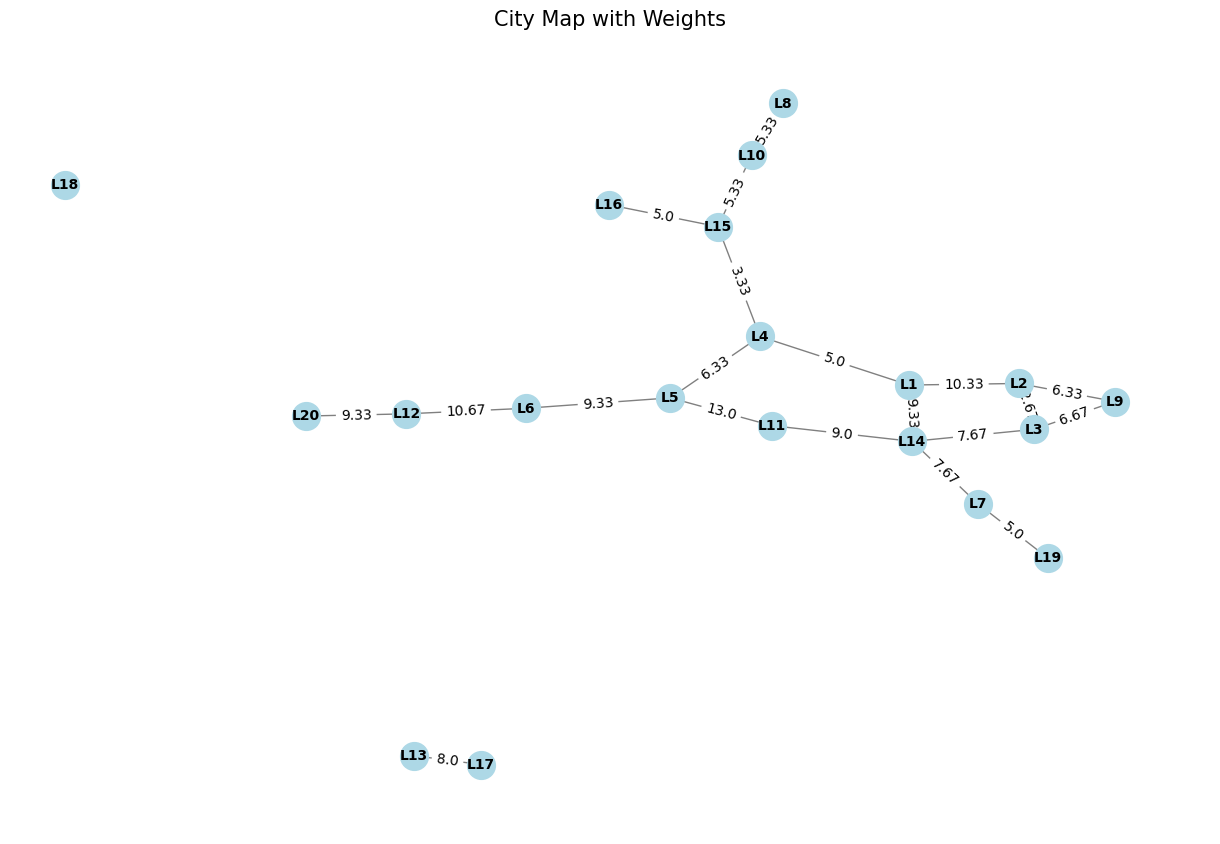

In [40]:
plt.figure(figsize=(12, 8))  # Set the figure size for better visibility
pos = nx.spring_layout(G, k=0.5, iterations=50)  # Adjust layout parameters to spread nodes
nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=400, font_size=10, font_weight='bold', edge_color='gray')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='black')
plt.title("City Map with Weights", fontsize=15)
plt.savefig("../screenshots/City_Map_with_Weights.png", dpi=200, bbox_inches="tight")
plt.axis('off')  # Turn off the axis
plt.show()

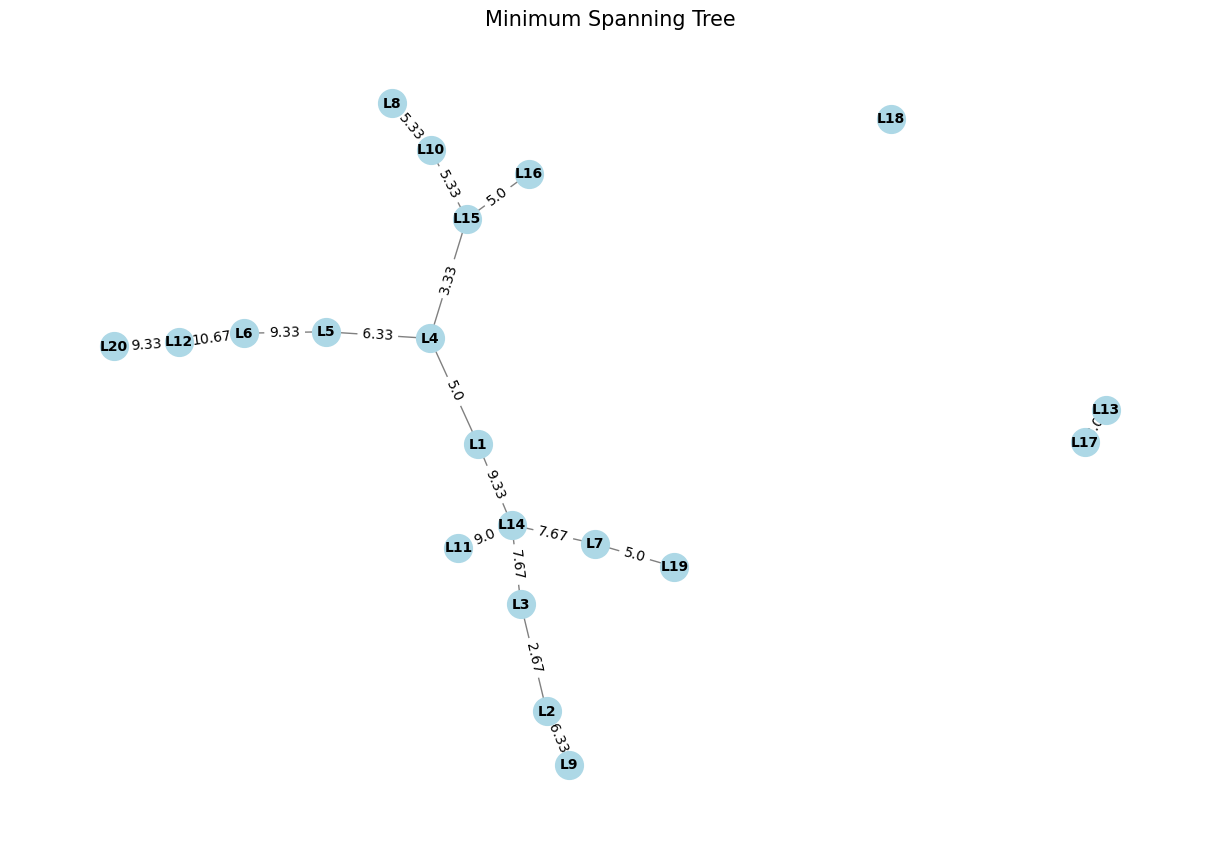

In [41]:
plt.figure(figsize=(12, 8))  # Set the figure size for better visibility
pos = nx.spring_layout(T, k=0.5, iterations=50)  # Adjust layout parameters to spread nodes
nx.draw(T, pos, with_labels=True, node_color="lightblue", node_size=400, font_size=10, font_weight='bold', edge_color='gray')
labels = nx.get_edge_attributes(T, 'weight')
nx.draw_networkx_edge_labels(T, pos, edge_labels=labels, font_color='black')
plt.title("Minimum Spanning Tree", fontsize=15)
plt.savefig("../screenshots/Minimum_Spanning_Tree.png", dpi=200, bbox_inches="tight")
plt.axis('off')  # Turn off the axis
plt.show()

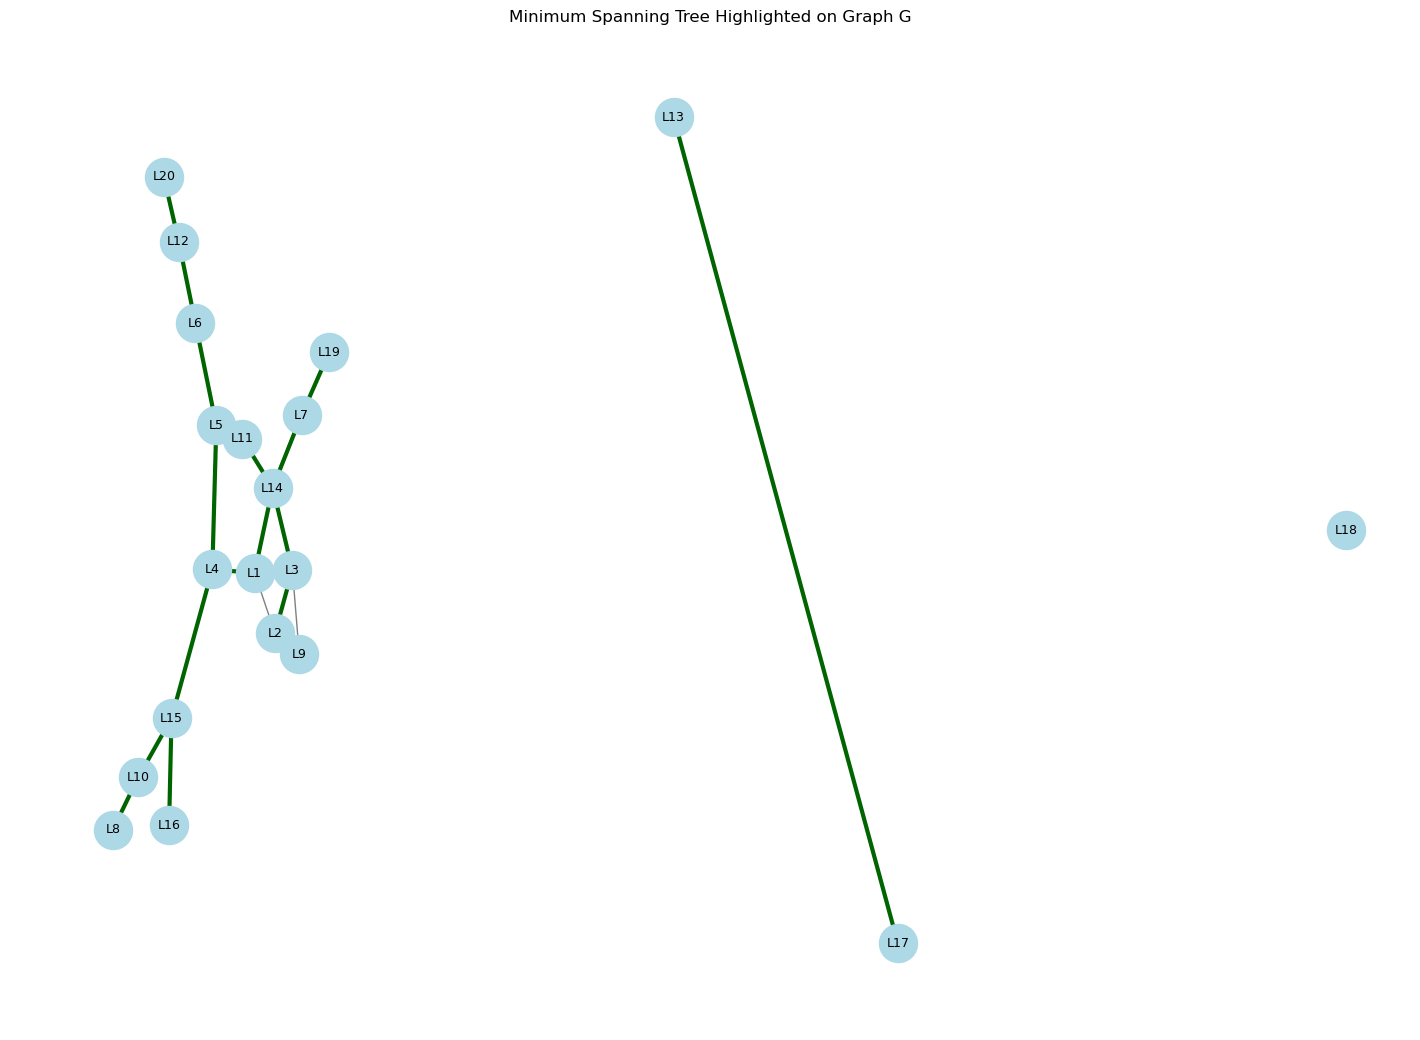

In [42]:
import networkx as nx
import matplotlib.pyplot as plt

# Create separated layouts for each connected component
components = list(nx.connected_components(G))
pos = {}

offset_x = 0
spacing = 5  # increase if components are still close

for comp in components:
    subgraph = G.subgraph(comp)
    sub_pos = nx.spring_layout(subgraph, seed=42)

    for node, (x, y) in sub_pos.items():
        pos[node] = (x + offset_x, y)

    offset_x += spacing

# MST edges from T
mst_edges = list(T.edges())

plt.figure(figsize=(14, 10))

# Draw full graph G
nx.draw(
    G, pos,
    node_color="lightgray",
    node_size=600,
    edge_color="gray",
    with_labels=True,
    font_size=9
)

# Highlight MST edges
nx.draw_networkx_edges(
    G, pos,
    edgelist=mst_edges,
    edge_color="darkgreen",
    width=3
)

# Highlight MST nodes
nx.draw_networkx_nodes(
    G, pos,
    nodelist=T.nodes(),
    node_color="lightblue",
    node_size=750
)

plt.title("Minimum Spanning Tree Highlighted on Graph G")
plt.savefig("../screenshots/Minimum_Spanning_Tree_Highlighted_on_Graph_G.png", dpi=200, bbox_inches="tight")
plt.axis("off")
plt.show()

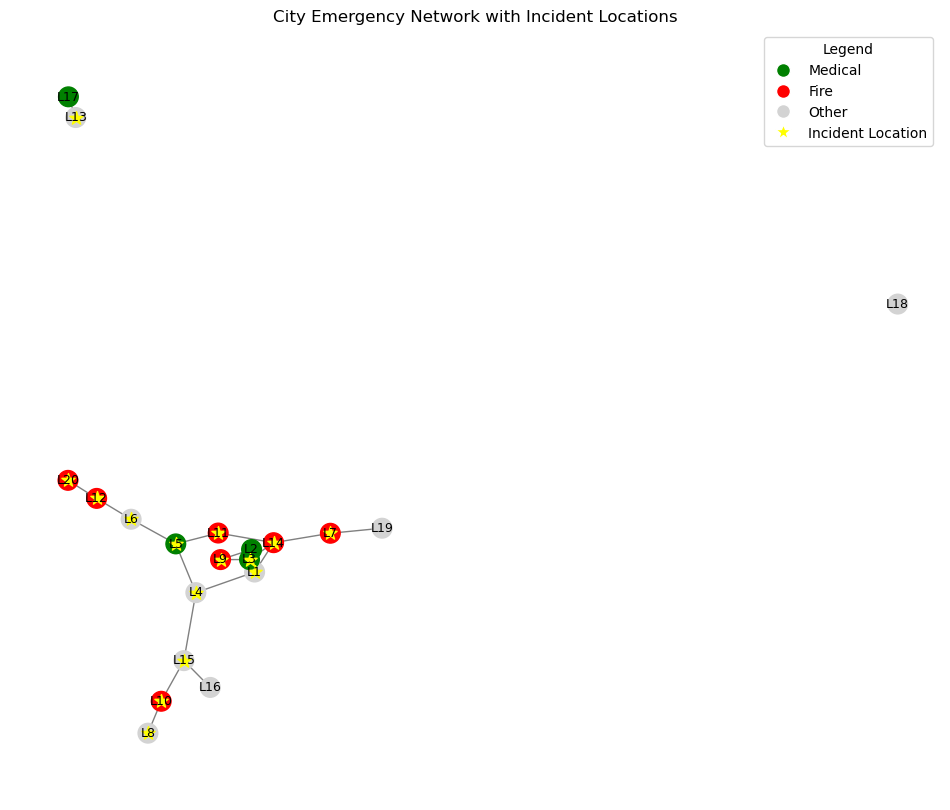

In [43]:
import networkx as nx
import matplotlib.pyplot as plt

facility_categories = {
    'Medical': ['L2', 'L3', 'L5', 'L17'],
    'Fire': ['L9', 'L10', 'L11', 'L12', 'L14', 'L20', 'L7']
}

category_colors = {
    'Medical': 'green',
    'Fire': 'red',
    'Other': 'lightgray'
}

# Assign colors to nodes
node_colors = []
for node in G.nodes():
    assigned = False
    for category, nodes in facility_categories.items():
        if node in nodes:
            node_colors.append(category_colors[category])
            assigned = True
            break
    if not assigned:
        node_colors.append(category_colors['Other'])

# Layout
pos = nx.spring_layout(G, seed=42)

fig, ax = plt.subplots(figsize=(12, 10))
fig.patch.set_facecolor('#6e5f4d')   
#ax.set_facecolor('#363534')

# Draw base graph
nx.draw(
    G, pos,
    node_color=node_colors,
    node_size=200,
    edge_color='gray',
    with_labels=True,
    font_size=9
)

# Highlight incident locations with a marker
nx.draw_networkx_nodes(
    G, pos,
    nodelist=incident_locations,
    node_color='yellow',
    node_size=100,
    node_shape='*'
)

# Legend
legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=color, markersize=10, label=category)
    for category, color in category_colors.items()
]

legend_handles.append(
    plt.Line2D([0], [0], marker='*', color='w',
               markerfacecolor='yellow', markersize=12, label='Incident Location')
)

plt.legend(handles=legend_handles, title="Legend")
plt.title("City Emergency Network with Incident Locations")
plt.savefig("../screenshots/Network_with_Incident_Locations.png", dpi=200, bbox_inches="tight")
plt.axis("off")
plt.show()